##Instalando y descargando librerías

In [5]:
!pip install Numpy Pandas Matplotlib yfinance beautifulsoup4 lxml

In [6]:
!python -V

Python 3.10.12


In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
import matplotlib.pyplot as plt

In [10]:
from matplotlib import colors

In [11]:
from matplotlib.collections  import  LineCollection

In [12]:
from matplotlib.colors  import  ListedColormap ,  BoundaryNorm

In [13]:
import matplotlib.patches as mpatches

In [14]:
import yfinance as yf

In [15]:
import requests

In [16]:
from bs4 import BeautifulSoup

In [17]:
from IPython.display import clear_output

In [18]:
import time

##Declaración de variables globales

In [19]:
global df_bitcoin, precio_actual, tendencia, tendencia_float, media_bitcoin,  algoritmo_decision, mediana_tratada


## Función para extraer el histórico de precios de Bitcoin en los últimos 7 días en intervalos de 5 minutos


In [20]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  # df_bitcoin DataFrame
  #1.Utiliza la biblioteca yfinance de Python para extraer el histórico de precios del Bitcoin en dólares BTC-USD
  #2.extraer el histórico de los últimos 7 días en intervalos de 5 minutos, este histórico deberás guardarlo en el dataframe df_bitcoin.
  #1:
  df_bitcoin = (yf.download('BTC-USD', period='7d', interval='5m').round(2))

  return df_bitcoin

##Función para realizar "Web Scraping" y extraer el valor actual del "Bitcoin" BTC en dólares USD


In [21]:
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia_float, tendencia, media_bitcoin,  algoritmo_decision
  #Web Scraping de la página https://coinmarketcap.com/ para extraer el precio actual del Bitcoin BTC en dólares USD y la variación de su precio en la última hora 1h %
  #El precio deberás convertirlo a float y guardarlo en la variable llamada precio_actual
  #Ahora, en la variable tendencia guarda el valor de 'baja'si la variación del precio es negativa, sino, guarda el valor de 'alta'.

  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'}
  url = 'https://coinmarketcap.com/'
  response = requests.get(url, headers=headers)
  soup = BeautifulSoup(response.content, "html.parser")
  #Print(response.text)
  precio_actual = []
  tendencia = []
  #precio_actual_str = soup.find('div',{'class':'sc-a0353bbc-0 gDrtaY'})
  #precio_actual = float(precio_actual_str.text.replace('$', '').replace(',', ''))

  indice = 0
  for item in soup:
    if item.getText() == 'BTC':
      break
      indice +=1

  lista = []
  precio_actual_str = soup.findAll('div',{'class':['sc-a0353bbc-0 gDrtaY', 'sc-a0353bbc-0 gDrtaY rise', 'sc-a0353bbc-0 gDrtaY fall']})
  precio_actual = float(precio_actual_str[indice].text.replace('$', '').replace(',', ''))
  tendencia_num = soup.findAll('span',{'class':['sc-d55c02b-0 iwhBxy', 'sc-d55c02b-0 gUnzUB']})
  for item in tendencia_num:
    lista.append(item)
  tendencia_float = float(tendencia_num[indice].text.replace('%', '').strip())

  tendencia = ''

  #Icono = icon-Caret-up, icon-Caret-down
  #print(lista[indice].find('span')['class'] [0] == 'icon-Caret-up')

  if (lista[indice].find('span')['class'] [0] == 'icon-Caret-down'):
    tendencia = 'baja'
    #print(lista[indice].text, f'-{tendencia_float}')
  else:
    tendencia = 'alta'
    #print(lista[indice].text, f'+{tendencia_float}')


  return precio_actual, tendencia, tendencia_float

##Función para realizar la limpieza de los datos, eliminar los Outliers



In [22]:
df_bitcoin = importar_base_bitcoin()
precio_actual, tendencia, tendencia_float = extraer_tendencias()
tendencia


[*********************100%%**********************]  1 of 1 completed


'alta'

In [23]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  #Aplicando un tratamiento de datos al DataFrame "df_bitcoin"

  df_bitcoin_limpio = df_bitcoin.copy()
  index = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = pd.DataFrame(data = df_bitcoin_limpio, index = index)
  df_bitcoin_limpio.Close.fillna(method = 'ffill', limit = 100)
  df_bitcoin_limpio.Close.fillna(method = 'bfill', limit = 100)
  df_bitcoin_limpio.Close.fillna(method = 'ffill', limit = 200)
  df_bitcoin_limpio.Close.fillna(method = 'bfill', limit = 200)
  df_bitcoin_limpio.Close.fillna(method = 'ffill', limit = 100)
  df_bitcoin_limpio.Close.fillna(method = 'bfill', limit = 100)
  df_bitcoin_limpio.Close.fillna(method = 'ffill', limit = 200)
  df_bitcoin_limpio.Close.fillna(method = 'bfill', limit = 200)
  seleccion = df_bitcoin_limpio['Volume'] <= 0
  df_bitcoin_limpio = df_bitcoin_limpio[~seleccion]

  #Aplicando BoxPlot:
  #DataFrame Original:

  plt.rc('figure', figsize= (14,6))
  print("Identificando Outliers en DataFrame original: ")
  g1_origin = df_bitcoin.boxplot('Close')
  g1_origin.set_title('Histórico de operaciones en BTC Orginal ($)')
  plt.show()

  #Eliminando OutLiers al DataFrame original:

  %matplotlib inline
  plt.rc('figure', figsize= (14,6))

  #Eliminando los OutLiers:
  valor = df_bitcoin.Close
  Q1 = valor.quantile(0.25) #Primer cuartil
  Q3 = valor.quantile(0.75) #Tercer cuartil
  #Precios entre el primer y tercer cuartil del BoxPlot
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ

  #Seleccion entre el primer cuartil y el tercer cuartil
  seleccion = (valor >= Q1) & (valor <= Q3)
  media_bitcoin_boxplot = df_bitcoin[seleccion]

  #Calculando el promedio del DataFrame original:
  #media_bitcoin = media_bitcoin_boxplot.Close.mean().round(2)

  #Grafico BoxPlot
  # fill with colors
  #colors = ['lightgreen', 'lightblue', 'lightgreen', 'pink']
  #media_bitcoin.boxplot(['Close'])
  # rectangular box plot
  labels = 'x1'
  print("Seleccion en DataFrame original")
  g1_origin_2 = media_bitcoin_boxplot.boxplot(['Close'],
                                  vert=True,  # vertical box alignment
                                  patch_artist=True, showmeans = True,
                                  meanline = True, boxprops = dict(facecolor = "lightblue"),
                                  medianprops = dict(color = "violet", linewidth = 1.5),
                                  capprops = dict(color = "blue", linewidth = 2),
                                  whiskerprops = dict(color = "blue", linewidth = 2))  # fill with color
  g1_origin_2.set_title('Histórico de operaciones en BTC original ($)')

  plt.show()

  #-----------------------------------------------------------------------------------------------------------
  #Para este desafio se utiliza el DataFrame "df_bitcoin_limpio":
  plt.rc('figure', figsize= (14,6))
  print("Identificando Outliers en DataFrame Tratado: ")
  g2_tratado = df_bitcoin.boxplot('Close')
  g2_tratado.set_title('Histórico de operaciones en BTC tratado ($)')

  plt.show()

   #Eliminando OutLiers al DataFrame Tratado:

  %matplotlib inline
  plt.rc('figure', figsize= (14,6))

  #Eliminando los OutLiers para DataFrame tratado:
  valor_tratado = df_bitcoin.Close
  Q1 = valor.quantile(0.25) #Primer cuartil
  Q3 = valor.quantile(0.75) #Tercer cuartil
  #Precios entre el primer y tercer cuartil del BoxPlot
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ

  #Seleccion entre el primer cuartil y el tercer cuartil
  seleccion = (valor_tratado >= Q1) & (valor_tratado <= Q3)
  media_bitcoin = df_bitcoin_limpio[seleccion]
  mediana_tratada = media_bitcoin.Close.median().round(2)

  #Grafico BoxPlot
  # fill with colors
  #colors = ['lightgreen', 'lightblue', 'lightgreen', 'pink']
  #media_bitcoin.boxplot(['Close'])
  # rectangular box plot
  print("Seleccion en DataFrame original")
  g2_tratado_2 = media_bitcoin.boxplot(['Close'],
                                  vert=True,  # vertical box alignment
                                  patch_artist=True, showmeans = True,
                                  meanline = True, boxprops = dict(facecolor = "lightblue"),
                                  medianprops = dict(color = "violet", linewidth = 1.5),
                                  capprops = dict(color = "blue", linewidth = 2),
                                  whiskerprops = dict(color = "blue", linewidth = 2))  # fill with color
  g2_tratado_2.set_title('Histórico de operaciones en BTC tratado ($)')

  plt.show()

  #Calculando el promedio del DataFrame original:
  media_bitcoin = media_bitcoin.Close.mean().round(2)

  return media_bitcoin, mediana_tratada

Identificando Outliers en DataFrame original: 


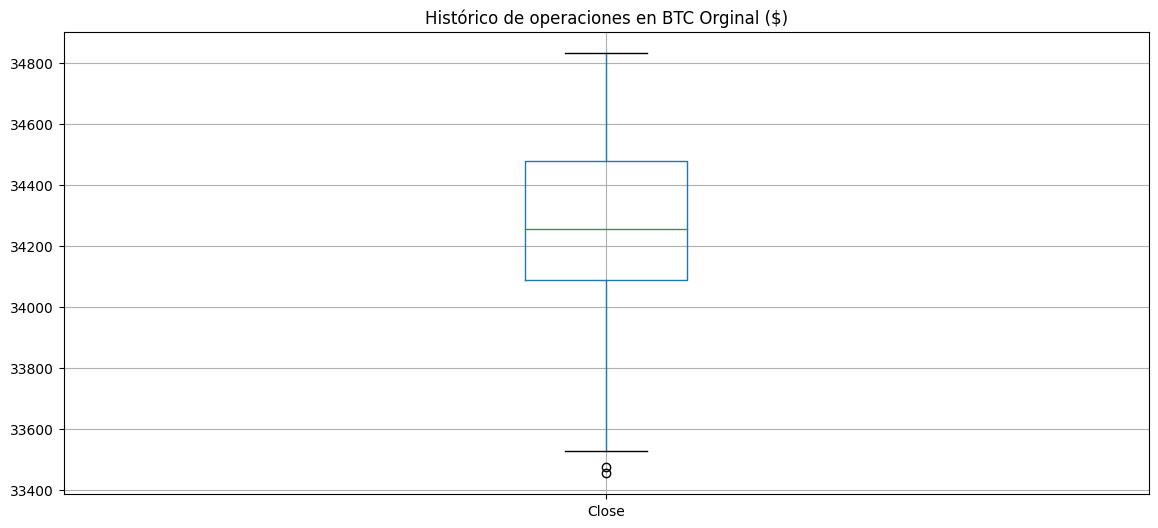

Seleccion en DataFrame original


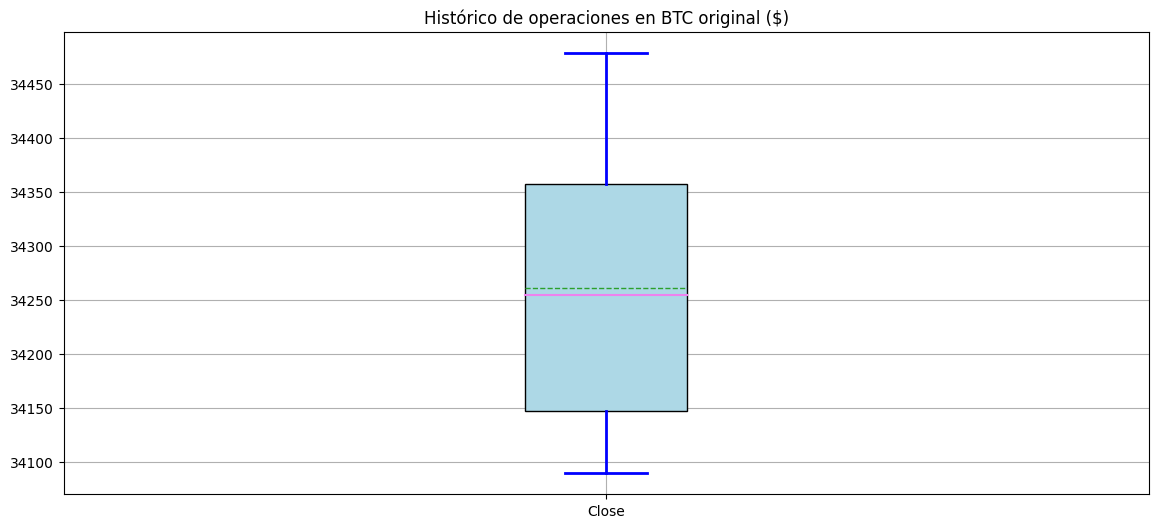

Identificando Outliers en DataFrame Tratado: 


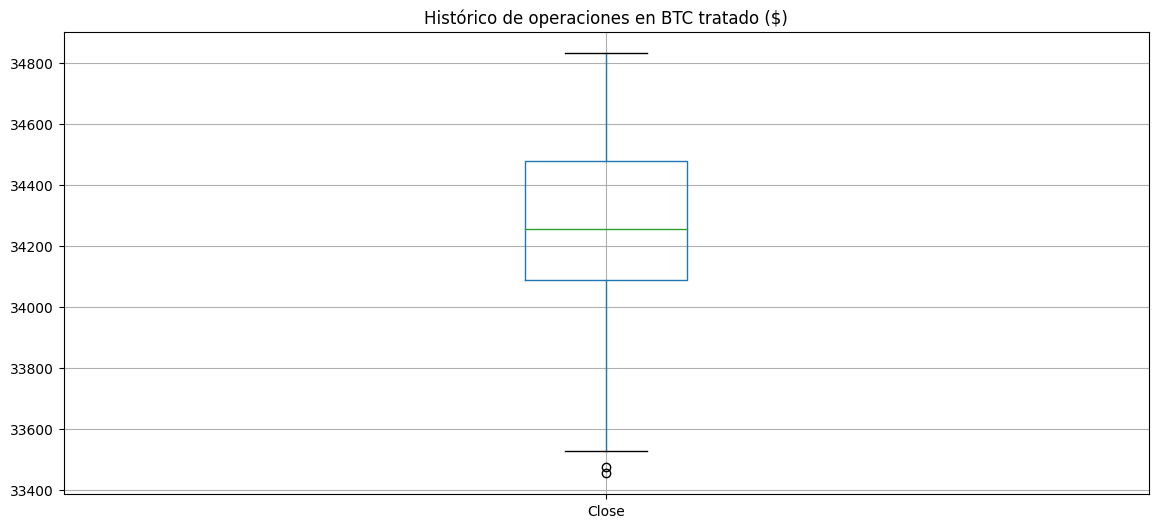

<ipython-input-23-adf4549dd421>:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  media_bitcoin = df_bitcoin_limpio[seleccion]


Seleccion en DataFrame original


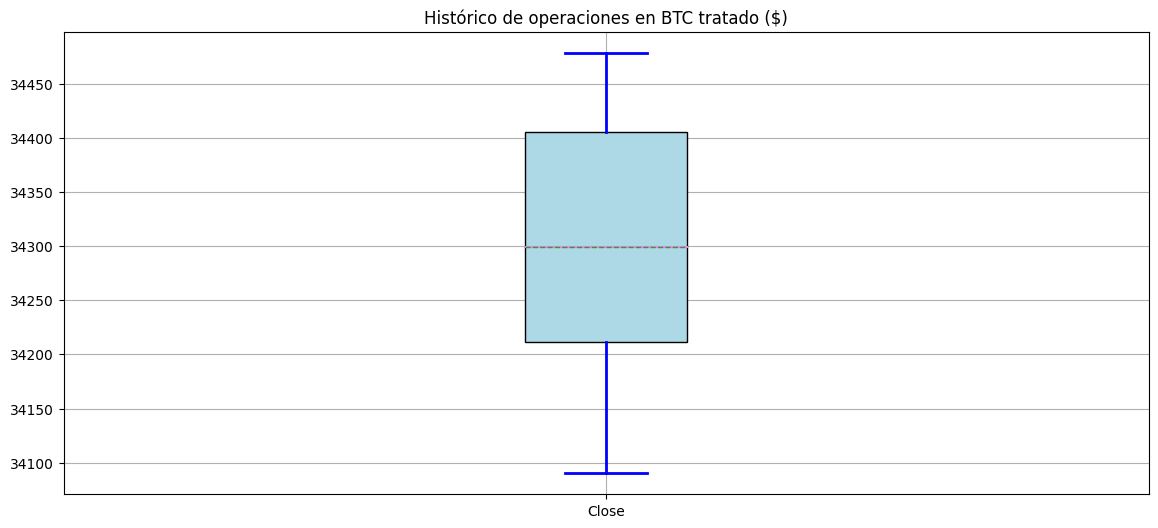

In [24]:
media_bitcoin, mediana_tratada = limpieza_datos()

In [25]:
mediana_tratada

34298.77

In [26]:
media_bitcoin

34298.7

## Función para la toma de decisiones en el histórico de los precios de cierre en el BTC ($)

In [27]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  precio_promedio = media_bitcoin
  algoritmo_decision = []

  if((precio_actual >= precio_promedio) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender'
    #print('Vender')
  elif((precio_actual < precio_promedio) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar'
    #print('Comprar')
  else:
    algoritmo_decision = 'Esperar'
    #print('Esperar')

  #print(algoritmo_decision)

  return algoritmo_decision

In [28]:
algoritmo_decision = tomar_decisiones()

##Función para la visualización de los datos provenientes del BTC ($)

In [31]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, tendencia_float, media_bitcoin,  algoritmo_decision, mediana_tratada

  df_bitcoin1 = df_bitcoin.copy()
  # Calcular la mediana de los precios de cierre
  df_bitcoin1['Promedio'] = media_bitcoin
  # Calcular la media de los precios de cierre
  df_bitcoin1['Promedio_median'] = df_bitcoin1.Close.median().round(2)

  plt.figure(figsize= (16,8))
  # Crear una lista de colores para los segmentos en función de si el valor actual es mayor o menor que la mediana
  colors = ['red' if x < media_bitcoin else 'blue' for x in df_bitcoin1.Close]

  #----------------------------------------------------------------------------------------------------------------------
  #Reporte de la gráfica principal
  print("Reporte del Histótico del BTC-USD: ")
  print(f" Valor actual: ${precio_actual}")
  if tendencia == 'baja':
    print(f" Valor de la tendencia: -{tendencia_float}%")
  else:
    print(f" Valor de la tendencia: +{tendencia_float}%")
  print(f" Tendencia: '{tendencia}'")
  print(f" Promedio Mediana: ${df_bitcoin1.Close.median().round(2)}")
  print(f" Promedio Media: ${media_bitcoin}")

  #----------------------------------------------------------------------------------------------------------------------
  # Graficar el historial con segmentos coloreados (Gráfica principal)
  for i in range(len(df_bitcoin1.Close) - 1):
    plt.plot(df_bitcoin1.index[i:i + 2], df_bitcoin1.Close.iloc[i:i + 2], color=colors[i], linewidth=2)
  # Crear etiquetas para la leyenda
  red_patch = mpatches.Patch(color='red', label='Valor Actual Menor que la Media')
  blue_patch = mpatches.Patch(color='blue', label='Valor Actual Mayor que la Media')

  # Configurar la leyenda
  plt.legend(handles=[red_patch, blue_patch])
  # Agregar una línea horizontal en la mediana
  plt.axhline(y=media_bitcoin, color='green', linestyle='--', label='Mediana')

  # Configurar el aspecto de la gráfica
  plt.title('Histórico de Bitcoin (BTC-USD), 7 días, Línea Segmentada Coloreada, datos tratados')
  plt.xlabel('Tiempo')
  plt.ylabel('Precio Actual del BTC ($)')
  plt.grid(True)

  #------------------------------------------------------------------------------------------------------------------------
  #Sub divisiones de graficos
  area = plt.figure(figsize= (16,8))
  area.suptitle('Graficos del historico de precios del BTC, 1_Original, 2_Tratado, 3_Mediana')
  #------------------------------------------------------------------------------------------------------------------------
  #Grafica 1
  g1 = area.add_subplot(2, 2, 1)
  x1 = df_bitcoin.index
  y1 = df_bitcoin.Close
  x21_1 = df_bitcoin.index[0]
  y21_1 = df_bitcoin.Close[0]
  x22_1 = df_bitcoin.index[-1]
  y22_1 = df_bitcoin.Close[-1]

  x21_21 = df_bitcoin1.index[0]
  y21_21 = df_bitcoin1.Promedio[0]
  x22_21 = df_bitcoin1.index[-1]
  y22_21 = df_bitcoin1.Promedio[-1]

  g1.plot(x1, y1,'g', [x21_1, x22_1], [y21_1, y22_1], 'violet', [x21_21, x22_21], [y21_21, y22_21], 'orange')
  g1.set_title('1_ Historico de precios original BTC, 7d ')
  g1.set_xlabel('Fechas en el volumen en transacciones')
  g1.set_ylabel('Precio Actual del BTC ($)')
  #------------------------------------------------------------------------------------------------------------------------
  #Grafica 2
  g2 = area.add_subplot(2, 2, 2)
  x2 = df_bitcoin1.index
  y2 = df_bitcoin1.Close
  x21_2 = df_bitcoin1.index[0]
  y21_2 = df_bitcoin1.Close[0]
  x22_2 = df_bitcoin1.index[-1]
  y22_2 = df_bitcoin1.Close[-1]

  x21_22 = df_bitcoin1.index[0]
  y21_22 = df_bitcoin1.Promedio[0]
  x22_22 = df_bitcoin1.index[-1]
  y22_22 = df_bitcoin1.Promedio[-1]

  x21_231 = df_bitcoin1.index[0]
  y21_231 = df_bitcoin1.Promedio_median[0]
  x22_231 = df_bitcoin1.index[-1]
  y22_231 = df_bitcoin1.Promedio_median[-1]

  # Crear una lista de colores para los segmentos en función de si el valor actual es mayor o menor que la mediana
  colors = ['red' if x < df_bitcoin1.Close.median().round(2) else 'blue' for x in df_bitcoin1.Close]

  # Graficar el historial con segmentos coloreados
  g2 = area.add_subplot(2, 2, 2)
  for i in range(len(df_bitcoin1.Close) - 1):
    g2.plot(df_bitcoin1.index[i:i + 2], df_bitcoin1.Close.iloc[i:i + 2], color=colors[i], linewidth=2)
  g2.plot([x21_2, x22_2], [y21_2, y22_2], 'brown')
  # Crear etiquetas para la leyenda
  red_patch = mpatches.Patch(color='red', label='Valor Actual Menor que la Mediana')
  blue_patch = mpatches.Patch(color='blue', label='Valor Actual Mayor que la Mediana')

  # Configurar la leyenda
  plt.legend(handles=[red_patch, blue_patch])
  # Agregar una línea horizontal en la mediana
  g2.axhline(y=df_bitcoin1.Close.median().round(2), color='violet', linestyle='-', label='Mediana')
  g2.axhline(y=media_bitcoin, color='green', linestyle='--', label='Media')

  g2.annotate('Mediana',
              xy=(x2[9], df_bitcoin1.Close.median().round(2)),
              xytext = (x2[9], df_bitcoin1.Close.median().round(2)+550),
              arrowprops = dict(facecolor = 'black', width = 0.2, headwidth = 8),
              horizontalalignment = 'center')
  g2.annotate('Promedio',
              xy=(x2[110], media_bitcoin),
              xytext = (x2[110], media_bitcoin +500),
              arrowprops = dict(facecolor = 'black', width = 0.2, headwidth = 8),
              horizontalalignment = 'center')

  if(algoritmo_decision == 'Comprar'):
    g2.annotate(algoritmo_decision, xy=(x2[2], y2.min()), fontsize=14, color='blue')
  elif(algoritmo_decision == 'Vender'):
    g2.annotate(algoritmo_decision, xy=(x2[2], y2.min()), fontsize=14, color='red')
  else:
    g2.annotate(algoritmo_decision, xy=(x2[2], y2.min()), fontsize=14, color='orange')

  #Mostrar la tendencia y el valor del precio actual en el cuadro de la grafica:
  plt.text(0.6, 0.2, f'Valor Actual: ${precio_actual:.2f}', transform=g2.transAxes, fontsize=12, color='lightblue')
  plt.text(0.6, 0.25, f"Tendencia: '{tendencia}'", transform=g2.transAxes, fontsize=12, color='lightblue')
  if tendencia == 'baja':
    plt.text(0.6, 0.30, f"Tendencia: '-{tendencia_float}'", transform=g2.transAxes, fontsize=11, color='lightblue')
  else:
    plt.text(0.6, 0.30, f"Tendencia: '+{tendencia_float}'", transform=g2.transAxes, fontsize=11, color='lightblue')
  #plt.annotate(0.8, 0.1,f'Precio actual: ${precio_actual:.2f}', transform=g2.transAxes, fontsize=12, color='lightblue')
  #g2.annotate(0.8, 0.05,f"Tendencia: '{tendencia}'", transform=g2.transAxes, fontsize=13, color='lightblue')

  #plt.text(0.8, 0.1, f'Valor Actual: ${current_price:.2f}', transform=ax.transAxes, fontsize=12)
  #plt.text(0.8, 0.05, f'Mediana: ${median_price:.2f}', transform=ax.transAxes, fontsize=12)

  #g2.annotate(f'Valor Actual: {precio_actual:.2f}', xy=(x2[-1], pd.min(), xytext=(x2[-1], precio_actual + 1000), arrowprops=dict(arrowstyle='->'))
  #plt.annotate(f'Mediana: {median_price:.2f}', xy=(bitcoin_data.index[0], median_price), xytext=(bitcoin_data.index[0], median_price + 1000), arrowprops=dict(arrowstyle='->'))

  #g2.plot(x2_pos, y2_pos,'b',x2_neg, y2_neg,'r', [x21_2, x22_2], [y21_2, y22_2], 'brown', [x21_22, x22_22], [y21_22, y22_22], 'violet', [x21_231, x22_231], [y21_231, y22_231], 'g--')
  #g2.plot(x2, y2,'b', [x21_2, x22_2], [y21_2, y22_2], 'violet', [x21_22, x22_22], [y21_22, y22_22], 'r')


  # Configurar el aspecto de la gráfica
  plt.title('2_Histórico de Bitcoin (BTC-USD) en los últimos 7 días con Línea Segmentada Coloreada')
  plt.xlabel('Tiempo')
  plt.ylabel('Precio Actual del BTC ($)')

  #------------------------------------------------------------------------------------------------------------------------
  #Grafica 3
  g3 = area.add_subplot(2, 2, 3)
  x3 = df_bitcoin1.index
  y3 = df_bitcoin1.Promedio
  x21_3 = df_bitcoin1.index[0]
  y21_3 = df_bitcoin1.Promedio[0]
  x22_3 = df_bitcoin1.index[-1]
  y22_3 = df_bitcoin1.Promedio[-1]

  x21_23 = df_bitcoin1.index[0]
  y21_23 = df_bitcoin1.Promedio[0]
  x22_23 = df_bitcoin1.index[-1]
  y22_23 = df_bitcoin1.Promedio[-1]

  g3.plot(x3, y3,'brown', [x21_3, x22_3], [y21_3, y22_3], 'violet', [x21_23, x22_23], [y21_23, y22_23], 'orange')
  #g3.annotate(f'Valor Mediana: ${media_bitcoin.Close.median().round(2)}', xy=(x2[556], y2[270]), fontsize=12, color='lightblue')
  plt.text(0.6, 0.1, f'Valor Actual: ${df_bitcoin1.Close.median().round(2):.2f}', transform=g3.transAxes, fontsize=12, color='lightblue')
  # Crear etiquetas para la leyenda
  orange_patch = mpatches.Patch(color='orange', label='Valor Actual de la Mediana')
  # Configurar la leyenda
  plt.legend(handles=[orange_patch])

  g3.set_title('3_ Valor Promedio (Mediana) BTC, 7d ')
  g3.set_xlabel('Fechas en el volumen en transacciones')
  g3.set_ylabel('Precio Actual del BTC ($)')

  #------------------------------------------------------------------------------------------------------------------------
  #Grafica 4

  g4 = area.add_subplot(2, 2, 4)
  x4 = df_bitcoin1.index
  y4 = df_bitcoin1.Close

  # Crear una lista de colores para los segmentos en función de si el valor actual es mayor o menor que la mediana
  colors = ['red' if x < mediana_tratada else 'blue' for x in df_bitcoin1.Close]

  # Graficar el historial con segmentos coloreados
  for i in range(len(df_bitcoin1.Close) - 1):
    g4.plot(df_bitcoin1.index[i:i + 2], df_bitcoin1.Close.iloc[i:i + 2], color=colors[i], linewidth=2)
  # Crear etiquetas para la leyenda
  red_patch4 = mpatches.Patch(color='red', label='Valor Actual Menor que la Mediana')
  blue_patch4 = mpatches.Patch(color='blue', label='Valor Actual Mayor que la Mediana')

  # Configurar la leyenda
  g4.legend(handles=[red_patch4, blue_patch4])
  # Agregar una línea horizontal en la mediana
  g4.axhline(y=mediana_tratada, color='violet', linestyle='-', label='Median_')
  g4.axhline(y=media_bitcoin, color='green', linestyle='--', label='Mean_')

  g4.annotate('Mediana',
              xy=(x4[9], mediana_tratada),
              xytext = (x4[9], mediana_tratada + 550),
              arrowprops = dict(facecolor = 'black', width = 0.2, headwidth = 8),
              horizontalalignment = 'center')
  g4.annotate('Promedio',
              xy=(x4[110], media_bitcoin),
              xytext = (x4[110], media_bitcoin + 500),
              arrowprops = dict(facecolor = 'black', width = 0.2, headwidth = 8),
              horizontalalignment = 'center')

  if(algoritmo_decision == 'Comprar'):
    g4.annotate(algoritmo_decision, xy=(x4[2], y4.min()), fontsize=14, color='blue')
  elif(algoritmo_decision == 'Vender'):
    g4.annotate(algoritmo_decision, xy=(x4[2], y4.min()), fontsize=14, color='red')
  else:
    g4.annotate(algoritmo_decision, xy=(x4[2], y4.min()), fontsize=14, color='orange')

  #Mostrar la tendencia y el valor del precio actual en el cuadro de la grafica:
  plt.text(0.6, 0.2, f'Valor Actual: ${precio_actual:.2f}', transform=g4.transAxes, fontsize=12, color='lightblue')
  plt.text(0.6, 0.25, f"Tendencia: '{tendencia}'", transform=g4.transAxes, fontsize=12, color='lightblue')
  if tendencia == 'baja':
    plt.text(0.6, 0.30, f"Tendencia: '-{tendencia_float}'", transform=g4.transAxes, fontsize=11, color='lightblue')
  else:
    plt.text(0.6, 0.30, f"Tendencia: '+{tendencia_float}'", transform=g4.transAxes, fontsize=11, color='lightblue')

  # Configurar el aspecto de la gráfica
  g4.set_title('4_Histórico (BTC-USD), 7d, (media y mediana valores tratados)')
  g4.set_xlabel('Tiempo')
  g4.set_ylabel('Precio Actual del BTC ($)')

  #------------------------------------------------------------------------------------------------------------------------
  #Imagenes guardadas para descargar:

  area.savefig('Histórico_datos_BTC_original_tratados.png', dpi = 300, bbox_inches = 'tight')
  extent1 = g1.get_window_extent().transformed(area.dpi_scale_trans.inverted())
  area.savefig('Histórico_datos_BTC_Original.png', bbox_inches=extent1)
  extent2 = g2.get_window_extent().transformed(area.dpi_scale_trans.inverted())
  area.savefig('Histórico_datos_BTC_tratado.png', bbox_inches=extent2)
  extent3 = g3.get_window_extent().transformed(area.dpi_scale_trans.inverted())
  area.savefig('Mediana.png', bbox_inches=extent3)
  extent4 = g4.get_window_extent().transformed(area.dpi_scale_trans.inverted())
  area.savefig('Histórico_BTC_Datos_Tratados', bbox_inches=extent4)

  #plt.grid(True)
  plt.show()

##Función Automatización de ejecuciones de las funciones globales

[*********************100%%**********************]  1 of 1 completed
Identificando Outliers en DataFrame original: 


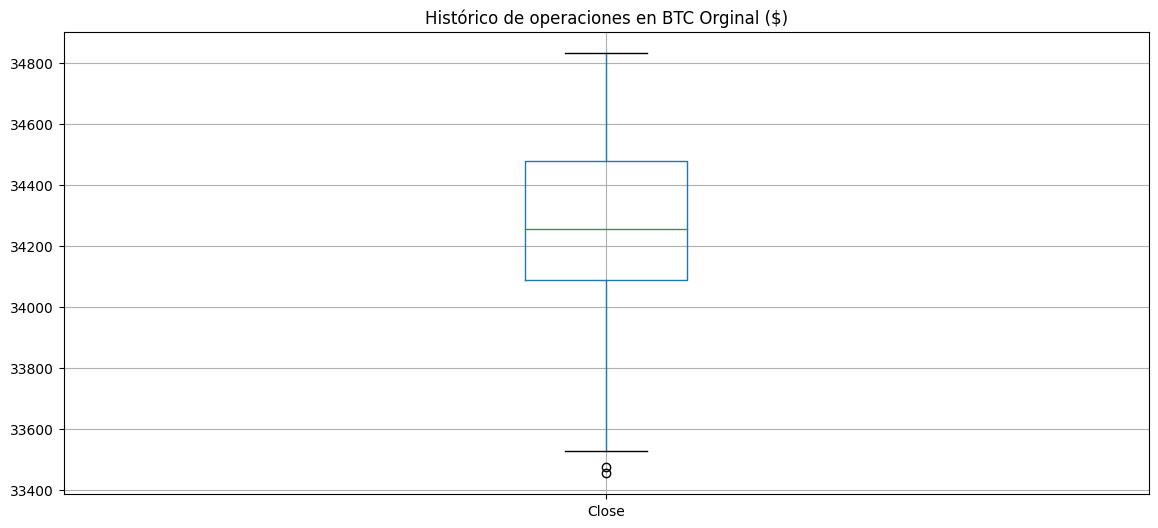

Seleccion en DataFrame original


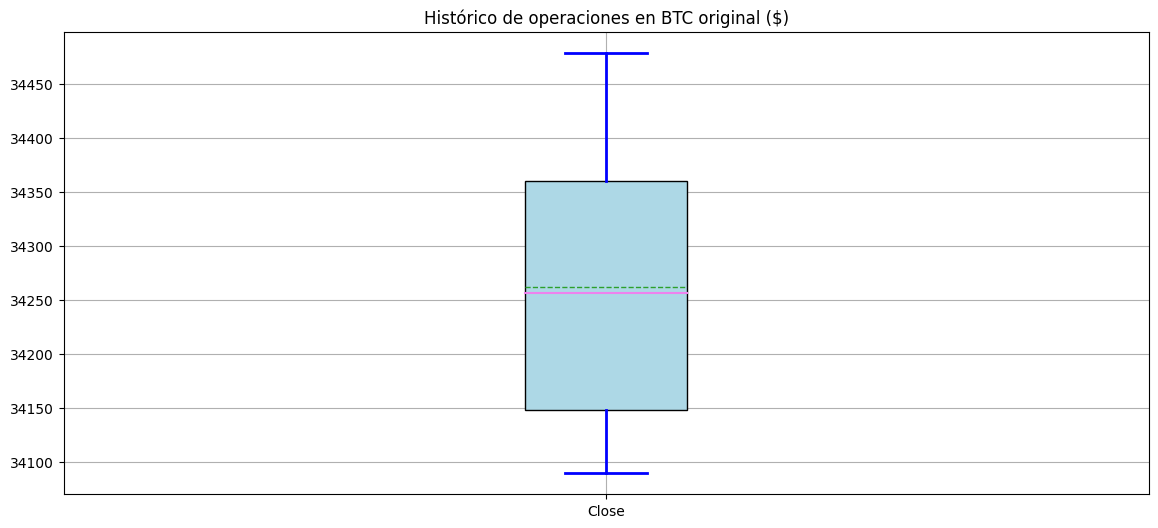

Identificando Outliers en DataFrame Tratado: 


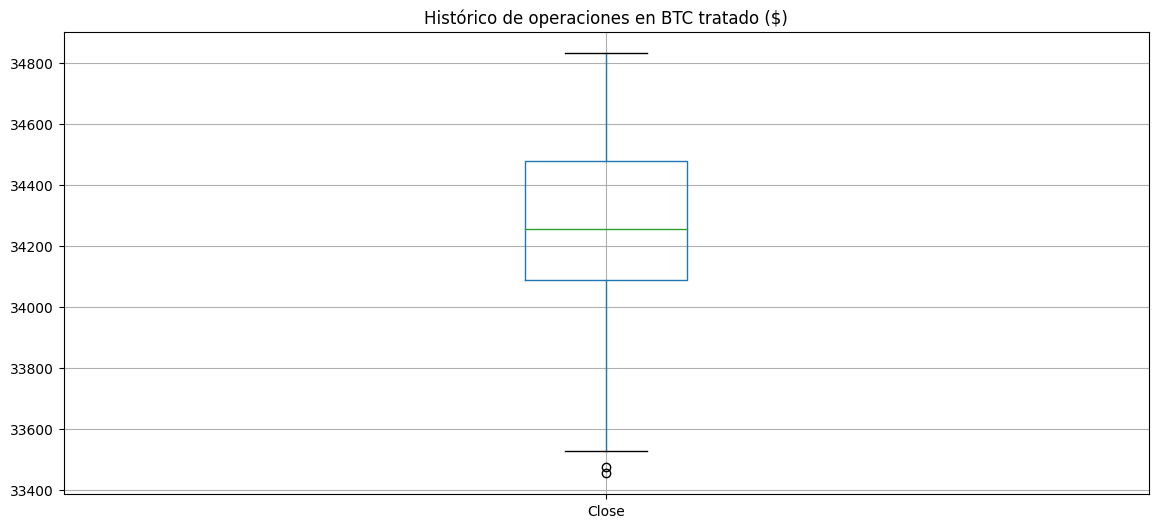

<ipython-input-23-adf4549dd421>:93: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  media_bitcoin = df_bitcoin_limpio[seleccion]


Seleccion en DataFrame original


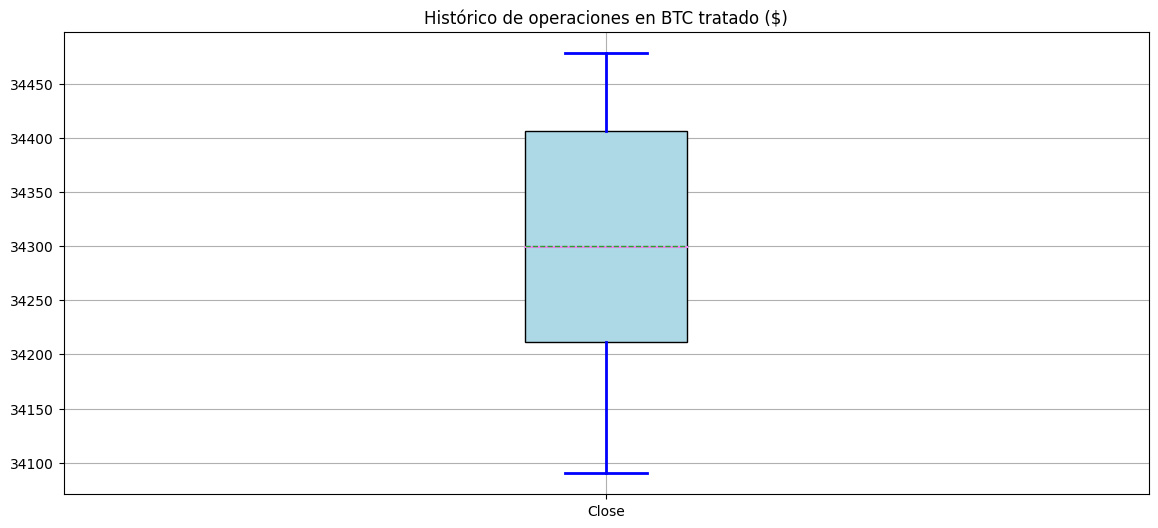

Reporte del Histótico del BTC-USD: 
 Valor actual: $34439.65
 Valor de la tendencia: +0.06%
 Tendencia: 'alta'
 Promedio Mediana: $34256.71
 Promedio Media: $34299.9


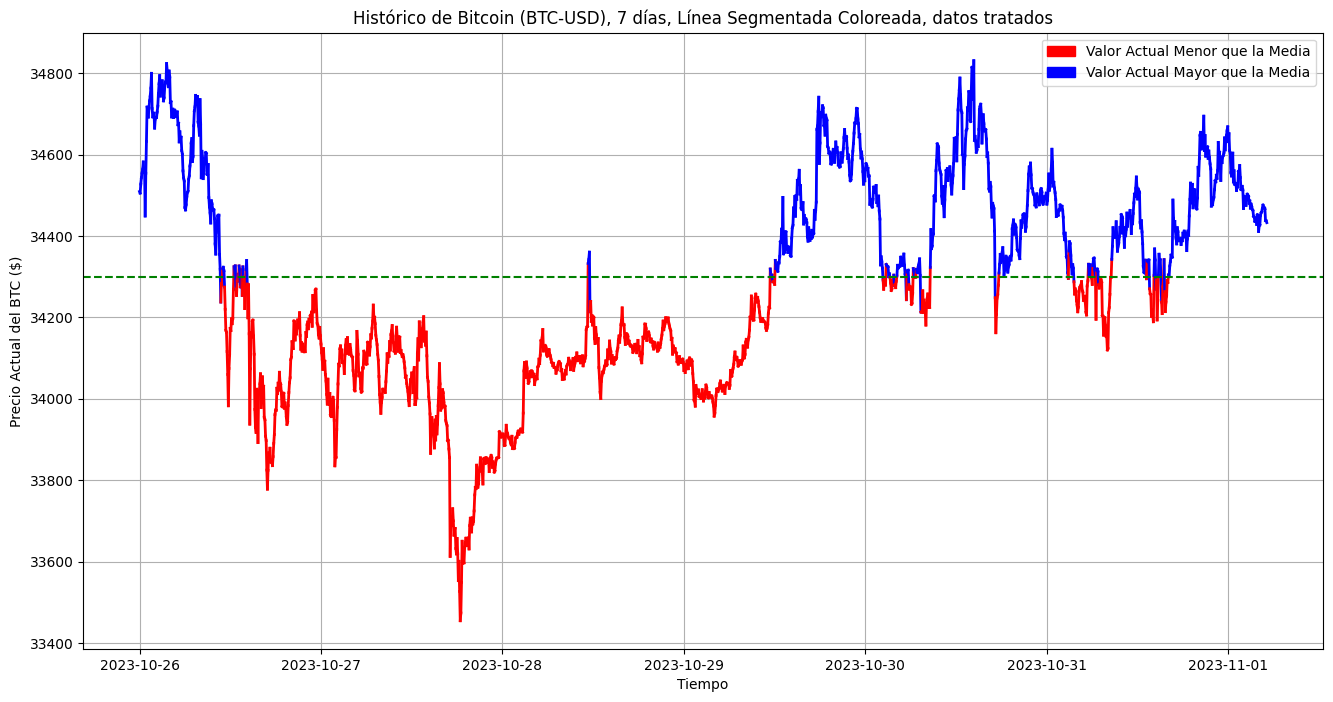

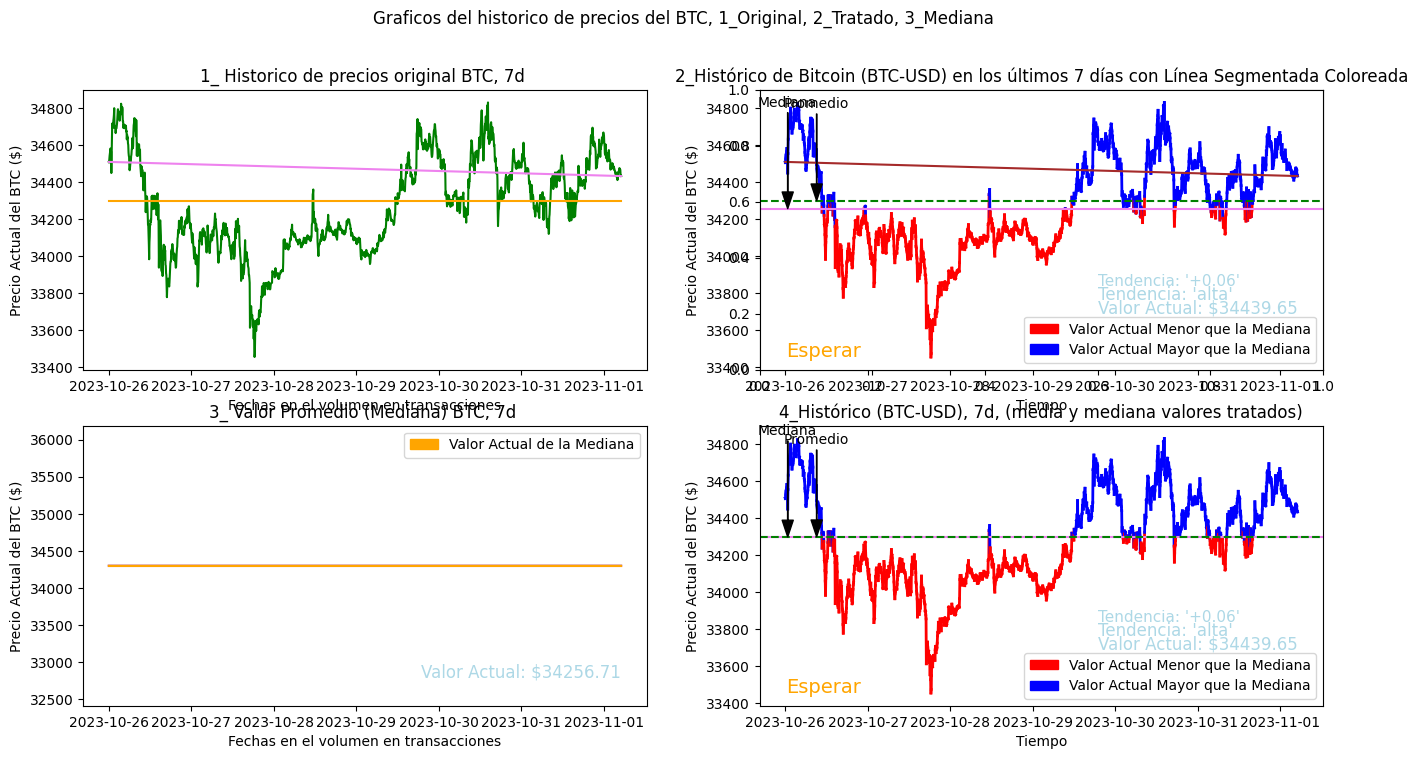

KeyboardInterrupt: ignored

In [32]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)

##Conclusiones

El Proyecto Robot Trading consta de 8 etapas:

1_ Descarga de librerías necesarias.
2_ Declaración de variables globales
3_ Función para extraer los datos del histórico de precios de Bitcoin en los últimos 7 días en intervalos de 5 minutos
4_ Función para realizar Web Scraping, para extraer el valor actual del Bitcoin BTC en dólar
5_ Función para realizar lalimpieza de los datos
6_Función para determinar que operación es recomendable, venta, compra o simplemente mantenerse en espera de un cambio en la tendencia.
7_ Función para imprimir los datos en pantalla.
8_Función para automatizar la ejecución de todas las funciones.

De las gráficas resultantes se tiene:
1_ una gráfica de color verde que identifica el histórico sin tratar, tal y como se muestra en la página de inversiones.
2_La gráfica representa la gráfica del Bitcoin en función a datos tratados, en el que se consideran los valores promedios en base a datos estádisticos, seleccionando el promedio de los datos de cierre en función al primer y tercer cuartíl de los datos tratados.
3_Representación gráfica del valor de la mediana.
4_La gráfica representa la gráfica del Bitcoin en función a datos tratados, en el que se consideran los valores promedios (media y mediana) en base a datos estádisticos, seleccionando el promedio de los datos de cierre en función al primer y tercer cuartíl de los datos tratados.La gráfica de BoxPlot representa los datos de mediana y valor promedio, en uno sólo el valor promedio (media_bitcoin) de los datos tratados, y un segundo gráfico con media y mediana en función a los datos limpios y tratados; en la segunda gráfica se observa que los valores de compra y venta están armónicamente divididos or el valor promedio y por la mediana, permitiendo determinar de manera un poco más precisa puntos de compra y venta.

La gráfica 2, posee una línea marrón que puede servir para determinar la velocidad de las inversiones en función del volúmen, a través del ángulo de inclinación entre las lineas promedio y los valores máximos, es recomendable mirarla en función del valor de la mediana.



##Exportando el DataFrame tratado

In [33]:
df_bitcoin.to_csv('Histórico_datos_BTC_tratado_Corregido2.csv', sep=';', index=False)

In [ ]:
##Fin de la primera parte del Robot Trading